# Week 5: Outlier detection

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Local imports
import sys
sys.path.append('..')
from utilities.load_data import load_iris_PC, load_iris, load_synthetic_data

## Exercise 1: Theory Questions
1. Please provide a brief definition of the task of outlier detection: what is the goal, and what are the challenges. 
2. Please provide a definition of an outlier according to the following approaches and discuss their similarities and differences:
    1. Statistical approaches 
    1. Distance-based (DB) 
    1. Local outlier factor (LOF) 
    1. Angle-based (ABOD) 
    1. Isolation-forest (IF) 
    1. HiCS 
3. Create small examples, either visually or as a brief textual description, of an outlier that is NOT (well) captured by
    1. DB-Outlier 
    1. LOF 
    1. ABOD 

## Exercise 2: Practical Example
Please consider the example data set below. Assuming Manhattan distance, please consider the following outlier detection setups.

<img src="graphics/W5.02.png" width="300"/>


In [4]:
def grid_data():
    return np.array([
        [1, 5], [2, 7], [3, 6], [3,7], [3,8], [4,5], [4,6], [4,7], [8,1], [8,4], [9,3], [9, 5]
    ])
X = grid_data()

1. For which parameters are the two highlighted objects outliers according to the distancebased definition (DB)?
1. According to cluster-based outlier detection using DBSCAN with $MinPts = 4$ (including the object itself) and $\epsilon = 3$ which objects are outliers?
1. In statistical approaches, a way to identify outliers in a given attribute is to single out all objects that deviate by more than three times the standard deviation from the mean in this attribute. Look at 1d and 2d plots to identify outliers.
1. Determine the LOF for the two highlighted objects $p_1=(1,5)$, $p_2=(8,1)$ for $k=3$, $MinPts=3$.

## Exercise 3: Comparing Isolation Forest and LOF with statistical methods
For this exercise, we will be using sklearn to do outlier detection. 
We will use [LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) 
and [IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).

We will use the following data.

/home/fhv/Projects/Instructor/dm20_exercises_public/utilities/data/iris-PC.txt
/home/fhv/Projects/Instructor/dm20_exercises_public/utilities/data/synth_multidim_010_000.arff


Text(0.5, 1.0, 'Hics subspace [8,9]')

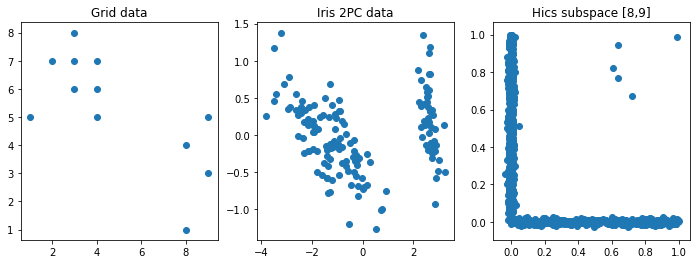

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
X_grid = grid_data()
X_iris, *_ = load_iris_PC()
X_hics, *_ = load_synthetic_data()
ax[0].scatter(*(X_grid.T))
ax[0].set_title('Grid data')
ax[1].scatter(*(X_iris.T))
ax[1].set_title('Iris 2PC data')
ax[2].scatter(*(X_hics[:,8:10].T))
ax[2].set_title('Hics subspace [8,9]')

In addition to LOF and IF, we will implement a simple version of `statistical_outliers` and `MDist`. 
For the former, we choose outliers as points where any of their features have a distance to the mean which exceeds $k$ standard deviations. 
For the latter, we normalize the data to have standard deviation 1 and then compute the $MDist(x, \mu) = (x-\mu)^T \Sigma^{-1} (x-\mu)$ where $\Sigma$ is an estimate of the covariance matrix.
`MDist` is going to take a threshold $k$, which decides the threshold for when a point is an outlier.

Fill in the following two method stubs.

In [ ]:
def statistical_outliers(X, k=3):
    # TODO implement statistical outliers.
    # return vector y where y[i] is -1 if point i is an outlier and 0 otherwise.
    pass

In [ ]:
def MDist(X, k=2):
    # TODO implement KDist
    # return vector y where y[i] is -1 if point i is an outlier and 0 otherwise.
    pass

Below is some code that runs the four algorithms on the different datasets.
_Before_ running the code, think about which points can be choosen as outliers for the different methods and which points cannot.

Does the resulting plots correspond to your expectations? If not, try to justify why?

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
k =  2
fig, ax = plt.subplots(3,4, figsize=(16, 12))

for i, data in enumerate(['Grid', 'Iris', 'Hics']):
    n_neighbors  = 10
    if data == 'Grid':
        X           = grid_data()
        n_neighbors = 2
    elif data == 'Iris':
        X, _        = load_iris_PC()
    elif data == 'Hics':
        X, _        = load_synthetic_data()

    # Find outliers
    y1 = statistical_outliers(X, k)
    y2 = MDist(X, k)
    y3 = IsolationForest(n_estimators=10).fit_predict(X)
    y4 = LocalOutlierFactor(n_neighbors=n_neighbors).fit_predict(X)

    if data == 'Hics': # Project 10D data onto 2 dimensions.
        #Hicks data set has outliers in subspace dimensions [0,1], [6,7], [8, 9], and [2,3,4,5]
        # You could try plotting other subspaces
        X = X[:, 8:10]

    # Plot data
    ax[i, 0].set_title("Stats. box")
    cf = ax[i, 0].scatter(*(X.T), c=y1)
    ax[i, 1].set_title("MDist")
    ax[i, 1].scatter(*(X.T), cmap=cf.get_cmap(), c=y2)
    ax[i, 2].set_title("Isolation Forest")
    ax[i, 2].scatter(*(X.T), c=y3)
    ax[i, 3].set_title("LOF")
    ax[i, 3].scatter(*(X.T), c=y4)
    
    ax[i, 0].set_ylabel(data)

## Exercise 4: ABOD
In this exercise, we will implement the exact ABOD scores as well as a simple sampling stratrgy for approximating the ABOD score.
Recall, that the ABOD score is defined as

$$
ABOD(p) = \text{var}_{x,y\in DB} \left[ \frac{\langle px, py \rangle}{||px||^2||py||^2} \right]
$$

where $px$ and $py$ are vectors from $p$ to $x$ and $y$, respectively.

Below is a template for computing the ABOD values. We will not do the refinement step of the approximation algorithm.
We will only compare full estimation of ABOD values with approdimations.
Implement the TODO and run the experiment below.

Please answer the following questions:
1. What can we tell from the experiment in terms of `sample_size` and quality of approximations?
2. If you were to implement the refinement step, how many samples would you use for selecting candidates?
3. Whey does sampling become slower than computing true ABOD when number of samples increase?


In [80]:
import time

def abod(i, X):
    """
        Compute ABOD for point x_i by comparing x_i to all other points in X.
        return score
    """
    n, d = X.shape
    p = X[i]
    X_   = np.delete(X, i, 0) # Remove x_i from X
    
    # TODO compute ABOD
    abod = 0
    
    return abod 

def fast_abod(i, X, sample_size=20):
    """
        Draw a random sample of `sample_size` points (not including x_i) and run the full `abod` function above on the subsample.
    """
    n, d = X.shape
    probs = np.ones((n,)) * (1/(n-1))                                         # Equal probability for all points but x_i
    probs[i] = 0.
    X_ = X[np.random.choice(X.shape[0], sample_size, replace=False, p=probs)] # Choose `sample_size` points from X at random.
    X_ = np.concatenate([X[i:i+1], X_], axis=0)                               # Add x_i to X_ at index 0 and call abod with index 0
    return abod(0, X_)

def ABOD(X, sample_size=-1):
    """
        Compute the ABOD value for all points in X 
    """
    fn = lambda i, X: fast_abod(i, X, sample_size) 
    if sample_size == -1: fn = abod
     
    A = []
    for i in range(X.shape[0]):
        A.append(fn(i, X))
    A = np.array(A)
    return np.clip(A, 0, 5)

In [ ]:
X, y = load_synthetic_data()
sel = np.argsort(y)[::-1] # Choose point such that we have some outliers to play with.
X = X[sel[:300]]
y = y[sel[:300]]

# Choose the first 300 rows and only the first two dimensions. 
# We can't choose too many rows as we are looking at an O(n^3) algorithm here.
X = X[:,8:10]
n, d = X.shape

sample_sizes = [2, 5, 10, 20, 40, 80, 160, n-1]
fig, ax = plt.subplots(len(sample_sizes), 2, figsize=(12, len(sample_sizes)*4))

times = []
runs  = 10

t0 = time.time()
for _ in range(runs): A1 = ABOD(X)
t_slow = time.time() - t0
t_slow /= runs

for i, ss in enumerate(sample_sizes):
    t0 = time.time()
    for _ in range(runs): A2 = ABOD(X, ss)
    t_fast = time.time() - t0
    t_fast /= runs
    
    times.append((t_slow, t_fast))
    cf = ax[i,0].scatter(*(X.T), c=A1)
    ax[i, 0].set_title("Slow")
    fig.colorbar(cf, ax=ax[i, 0])
    
    cf = ax[i,1].scatter(*(X.T), c=A2)
    ax[i,1].set_title("Fast, ss=%i" % ss)
    fig.colorbar(cf, ax=ax[i, 1])    

plt.tight_layout()

fig, ax = plt.subplots(1,1)
times = np.array(times).T
print(times.shape)
print(len(sample_sizes))
ax.plot(sample_sizes, times[0], 'r-', label="Slow")
ax.plot(sample_sizes, times[1], 'b',  label="Approx.")
fig.legend()